In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle 

from xgboost import XGBClassifier
import xgboost as xgb 
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scripts.lgbmHelper import LGBMHelper
from scripts.xgbHelper import XGBHelper

## Load Data

In [2]:
# train = pd.read_csv("./train_features.csv", index_col=0)
# test = pd.read_csv("./test_features.csv", index_col=0)
# test_all = pd.read_csv("./test.csv", names=['row_ID', 'text_a_ID', 'text_b_ID', 'text_a_text', 'text_b_text', 'have_same_meaning'], index_col=0)
# train_all = pd.read_csv("./train.csv", names=['row_ID', 'text_a_ID', 'text_b_ID', 'text_a_text', 'text_b_text', 'have_same_meaning'], index_col=0)

In [3]:
train_all = pd.read_csv("./train.csv", names=['row_ID', 'text_a_ID', 'text_b_ID', 'text_a_text', 'text_b_text', 'have_same_meaning'], index_col=0)
train_nlp_features = pd.read_csv("data/nlp_features_train.csv")
train_non_nlp_features = pd.read_csv("data/non_nlp_features_train.csv")
train_distance_features = pd.read_csv("data/distance_features_train.csv")
#train = pd.concat((train_nlp_features, train_non_nlp_features, train_distance_features), axis=1)
train = train_distance_features#pd.concat((train_nlp_features), axis=1)

test_all = pd.read_csv("./test.csv", names=['row_ID', 'text_a_ID', 'text_b_ID', 'text_a_text', 'text_b_text', 'have_same_meaning'], index_col=0)
test_nlp_features = pd.read_csv("data/nlp_features_test.csv")
test_non_nlp_features = pd.read_csv("data/non_nlp_features_test.csv")
test_distance_features = pd.read_csv("data/distance_features_test.csv")
#test = pd.concat((test_nlp_features, test_non_nlp_features, test_distance_features), axis=1)
test = test_distance_features#pd.concat((test_nlp_features), axis=1)

In [4]:
train = train.dropna(axis=1)
train =train.replace([np.inf, -np.inf], -1)

test = test.dropna(axis=1)
test= test.replace([np.inf, -np.inf], -1)

In [5]:
train_ensemble = train.copy()
test_ensemble = test.copy()

## Folds

In [6]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
kfold_splits = list(kfold.split(train))

## Train Models

In [7]:
models = [(LGBMHelper(), False),
          (LogisticRegression(solver='lbfgs', max_iter=1000), True), 
          (RandomForestClassifier(), False),
          (GradientBoostingClassifier(), False),
          (XGBHelper(), False),
          (KNeighborsClassifier(n_neighbors=3), True)]

In [ ]:
results = {}

for i, (model,scale) in enumerate(models):
    print("-----------------------------------------------------------")
    print("Train model {}".format(model.__class__.__name__))
    print("-----------------------------------------------------------")
    log_loss_fold = []
    print("Split ", end="")
    for j, (train_indices, test_indices) in enumerate(kfold_splits):
        print(str(j+1) + ",", end=" ")
        X_train = train.iloc[train_indices].astype(np.float64)
        y_train = train_all.have_same_meaning.iloc[train_indices].astype(np.float64)
        
        X_test = train.iloc[test_indices].astype(np.float64)
        y_test = train_all.have_same_meaning.iloc[test_indices].astype(np.float64)
        
        if scale: 
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
        model.fit(X_train, y_train)
        
        train_pred = model.predict_proba(train.iloc[test_indices,:])
        test_pred = model.predict_proba(test)

        if len(train_pred.shape) > 1 and train_pred.shape[1] == 2:
            train_pred = train_pred[:,1]
            test_pred = test_pred[:,1]

        train_ensemble.loc[test_indices,"predictions_" + model.__class__.__name__] = train_pred
        test_ensemble["predictions" + model.__class__.__name__] = test_pred
        
        df = pd.DataFrame({"is_duplicate": test_pred, "Id": test.index})
        df.to_csv("preds_" + model.__class__.__name__ + str(j) + ".csv")
        log_loss_fold.append(log_loss(y_test, train_pred))
                
    loss = np.mean(log_loss_fold)
    results[model.__class__.__name__] = loss

    print("")
    print("Result model {}: {}".format(model.__class__.__name__,loss))

-----------------------------------------------------------
Train model LGBMHelper
-----------------------------------------------------------
Split 1, 2, 3, 4, 5, 
Result model LGBMHelper: 0.40693416214298395
-----------------------------------------------------------
Train model LogisticRegression
-----------------------------------------------------------
Split 1, 2, 3, 4, 

In [ ]:
results

## Train Final Model

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(train_ensemble, train_all.have_same_meaning, test_size=0.2, random_state=4242)

d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid)
d_test = lgb.Dataset(test_ensemble)

# Set our parameters for xgboost
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 5,
    'learning_rate': 0.01,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'verbose': 0,
    'max_depth':5
}
bst = lgb.train(params,
                d_train,
                num_boost_round=10000,
                verbose_eval=300,
                valid_sets=[d_train, d_valid],
                early_stopping_rounds=300)

Training until validation scores don't improve for 300 rounds.
[300]	training's binary_logloss: 0.234722	valid_1's binary_logloss: 0.232172
[600]	training's binary_logloss: 0.224421	valid_1's binary_logloss: 0.222681
[900]	training's binary_logloss: 0.223181	valid_1's binary_logloss: 0.222629
Early stopping, best iteration is:
[702]	training's binary_logloss: 0.22391	valid_1's binary_logloss: 0.222576


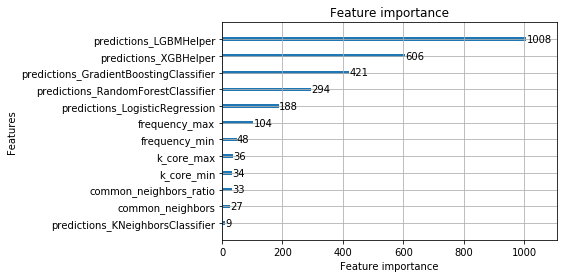

In [11]:
ax = lgb.plot_importance(bst, max_num_features=20)
plt.show()

In [12]:
n_iter = bst.best_iteration

d_train = lgb.Dataset(train_ensemble, label=train_all.have_same_meaning)
d_test = lgb.Dataset(test_ensemble)

bst = lgb.train(params,
                d_train,
                num_boost_round=n_iter,
                valid_sets=[d_train],
                verbose_eval=300)

[300]	training's binary_logloss: 0.234217
[600]	training's binary_logloss: 0.224052


In [13]:
# #Features for weighted graph

# y_test_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
# y_train_pred = bst.predict(train, num_iteration=bst.best_iteration)

# df_test_res = pd.DataFrame(y_test_pred, columns=["weight"])
# df_test_res.to_csv("./data/predictions_test.csv")

# df_train_res = pd.DataFrame(y_train_pred, columns=["weight"])
# df_train_res.to_csv("./data/predictions_train.csv")

## Evaluate Results

## Submit results

In [14]:
y_pred = bst.predict(test_ensemble, num_iteration=bst.best_iteration)
submission = pd.DataFrame(test.index.values, columns=["Id"])
submission["Score"] = y_pred
submission.to_csv("submission.csv", index=None)